# Preparing Alpha Factors and Features to predict Stock Returns

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2013-01-01'
END = '2017-12-31'

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Loading Quandl Wiki Stock Prices & Meta Data

In [6]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [7]:
DATA_STORE = '../data/assets.h5'

In [8]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])

## Remove stocks with few observations

In [9]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

### Align price and meta data

In [10]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [11]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [12]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2904233 non-null  float64
 1   close   2904233 non-null  float64
 2   low     2904233 non-null  float64
 3   high    2904233 non-null  float64
 4   volume  2904233 non-null  float64
dtypes: float64(5)
memory usage: 122.6+ MB


In [13]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2345 non-null   float64
 1   ipoyear    1026 non-null   float64
 2   sector     2348 non-null   object 
dtypes: float64(2), object(1)
memory usage: 73.4+ KB


In [14]:
stocks.sector.value_counts()

consumer_services        440
finance                  393
health_care              297
technology               297
capital_goods            227
basic_industries         138
consumer_non-durables    126
energy                   123
public_utilities         105
consumer_durables         78
miscellaneous             69
transportation            55
Name: sector, dtype: int64

Optional: persist intermediate results:

In [15]:
# with pd.HDFStore('tmp.h5') as store:
#     store.put('prices', prices)
#     store.put('stocks', stocks)

In [16]:
# with pd.HDFStore('tmp.h5') as store:
#     prices = store['prices']
#     stocks = store['stocks']

## Compute Rolling Average Dollar Volume

In [17]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

In [18]:
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker')
                           .rolling(window=21, level='date')
                           .mean()).values

In [19]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           2904233 non-null  float64
 1   close          2904233 non-null  float64
 2   low            2904233 non-null  float64
 3   high           2904233 non-null  float64
 4   volume         2904233 non-null  float64
 5   dollar_vol     2904233 non-null  float64
 6   dollar_vol_1m  2857273 non-null  float64
dtypes: float64(7)
memory usage: 166.9+ MB


In [20]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [21]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
dtypes: float64(8)
memory usage: 189.1+ MB


## Add some Basic Factors

### Compute the Relative Strength Index

In [22]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

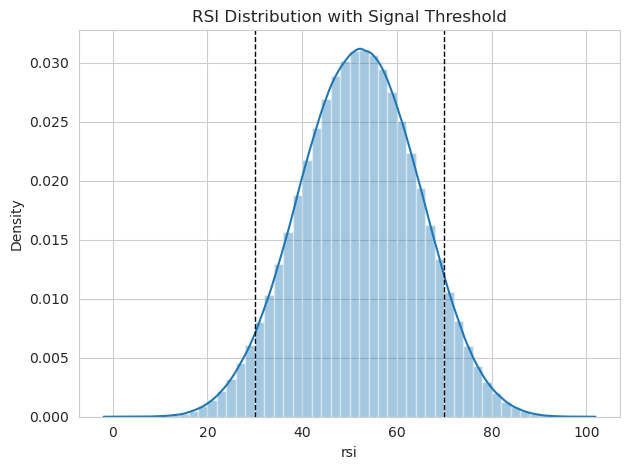

In [23]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [24]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [25]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [26]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

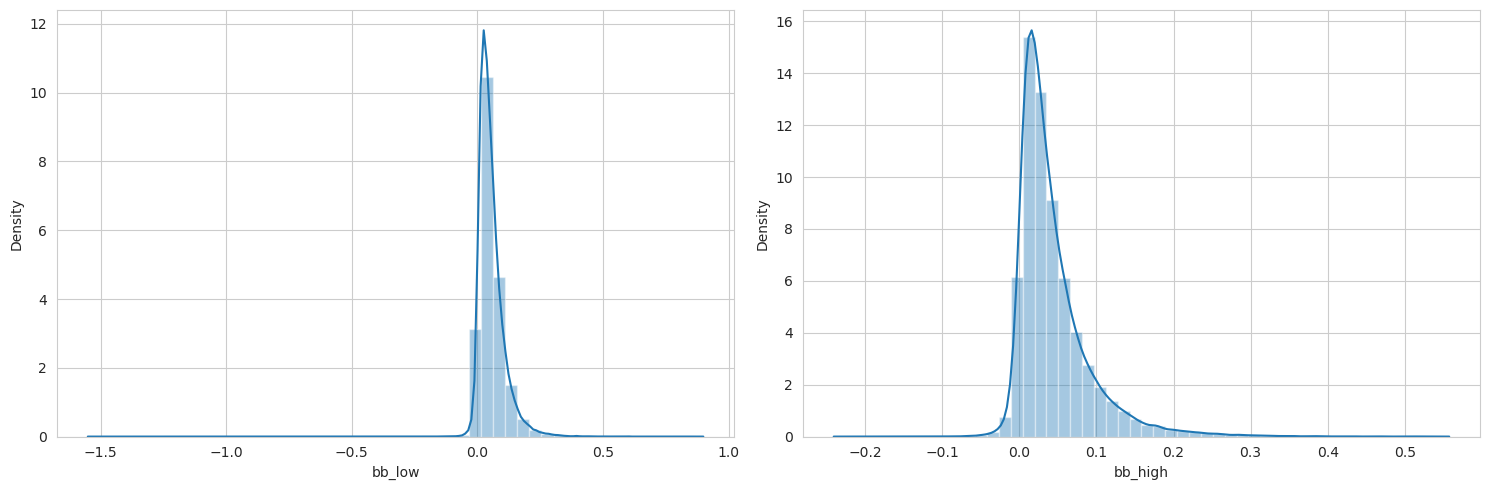

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [28]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [29]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

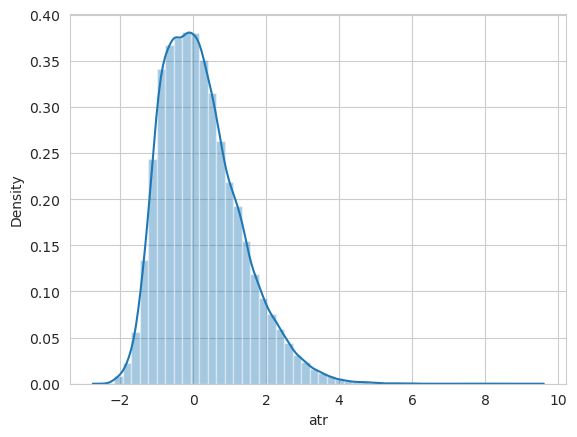

In [30]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

### Compute Moving Average Convergence/Divergence

In [31]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [32]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [33]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    2,826,749.0
mean            -0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

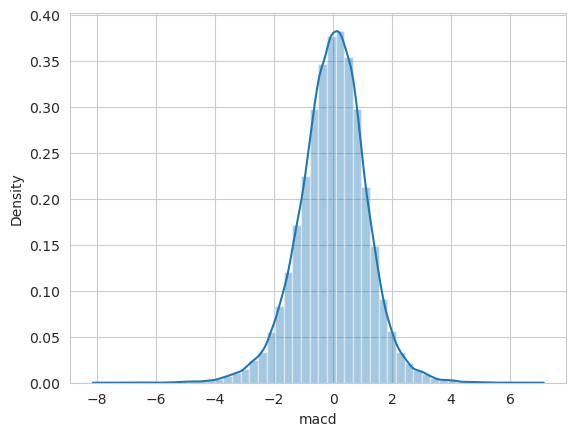

In [34]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## Compute Lagged Returns

In [35]:
lags = [1, 5, 10, 21, 42, 63]

In [36]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,9.37%
min,-87.62%
0.01%,-33.40%
0.1%,-14.78%
1%,-6.52%
50%,0.04%
99%,6.98%
99.9%,17.03%
99.99%,39.25%
max,"10,280.40%"


In [37]:
q = 0.0001

### Winsorize outliers

In [38]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift lagged returns

In [39]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

## Compute Forward Returns

In [40]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [41]:
prices = prices.join(stocks[['sector']])

## Create time and sector dummy variables

In [42]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [43]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
 8   rsi              2871361 non-null  float64
 9   bb_high          2859618 non-null  float64
 10  bb_low           2859585 non-null  float64
 11  atr              2871361 non-null  float64
 12  macd             2826749 non-null  float64
 13  return_1d        2901885 non-null  float64
 14  return_5d        2892493 non-null  float6

In [44]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')

In [45]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [46]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   open                   2904233 non-null  float64
 1   close                  2904233 non-null  float64
 2   low                    2904233 non-null  float64
 3   high                   2904233 non-null  float64
 4   volume                 2904233 non-null  float64
 5   dollar_vol             2904233 non-null  float64
 6   dollar_vol_1m          2857273 non-null  float64
 7   dollar_vol_rank        2857273 non-null  float64
 8   rsi                    2871361 non-null  float64
 9   bb_high                2859618 non-null  float64
 10  bb_low                 2859585 non-null  float64
 11  atr                    2871361 non-null  float64
 12  macd                   2826749 non-null  float64
 13 

## Store Model Data

In [47]:
prices.to_hdf('data.h5', 'model_data')

## Explore Data

### Plot Factors

In [48]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

### RSI

In [49]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [50]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4209.0,0.001126,0.010457,-0.067138,-0.003606,0.001051,0.006156,0.061889
"(30, 70]",107244.0,0.000446,0.007711,-0.170571,-0.003054,0.000650,0.004246,0.075653
"(70, 100]",10634.0,0.000018,0.006354,-0.087857,-0.002818,0.000145,0.003121,0.058570


### Bollinger Bands

-2.68% (0.00%)


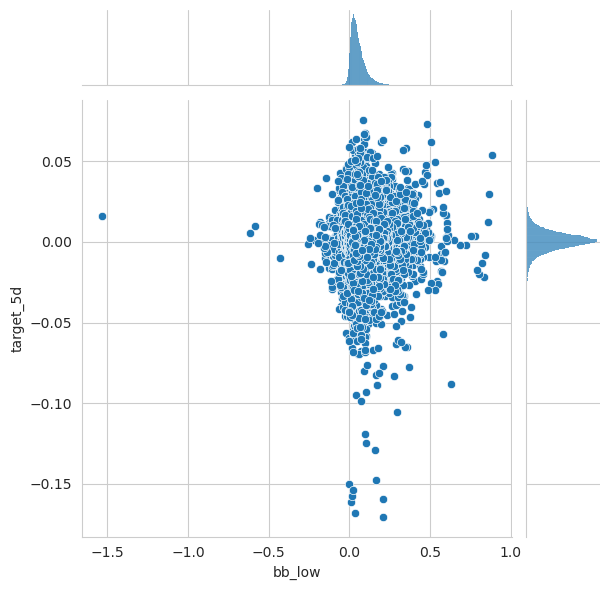

In [51]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

4.21% (0.00%)


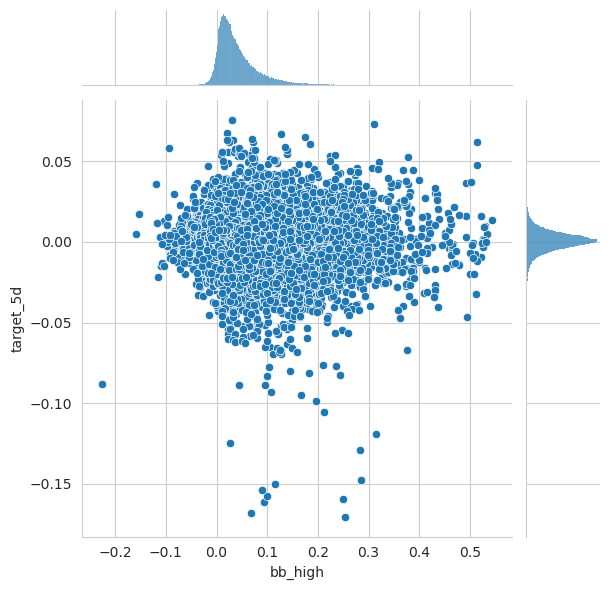

In [52]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### ATR

0.07% (80.08%)


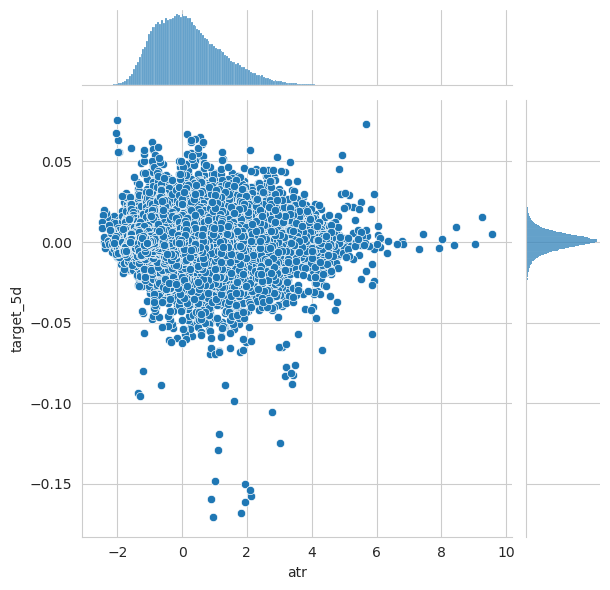

In [53]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### MACD

-4.72% (0.00%)


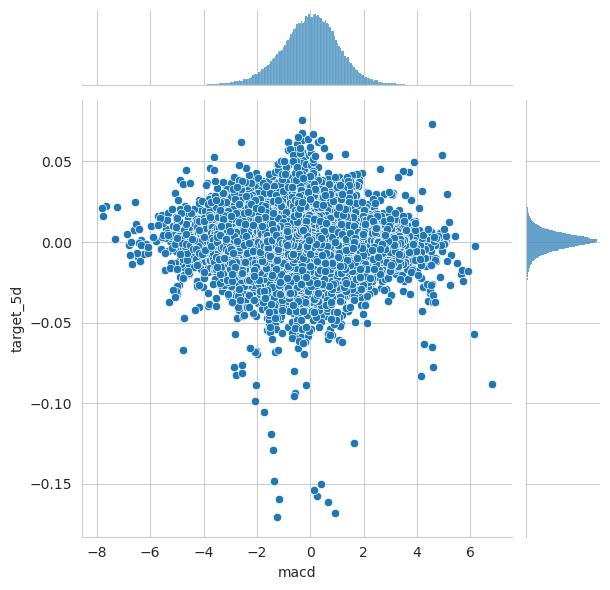

In [54]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')